In [7]:
import numpy as np
from numpy import sqrt, sin, cos, arccos
import matplotlib.pyplot as plt
from matplotlib import cm
import sympy as sp
from tqdm import tqdm
from numba import njit

from scipy.interpolate import splrep, splev, interp1d

plt.rc("font", family="serif", size=20)
plt.rc("mathtext", fontset="cm")
plt.rc("lines", lw=2)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle="--", alpha=1)

In [3]:
a = lambda mu : arccos(1 / mu**2)
u = lambda mu : 1 - cos(a(mu)) + 3/2 * mu**2 * sin(a(mu))**2
p = lambda mu : cos(a(mu)) - 1 + 1/2 * mu**2 * sin(a(mu))**2

[1.                 1.0000000499999988 1.0000000617741425]
[0.0000000000000000e+00 4.9999995019767664e-15 7.6320888860998803e-15]


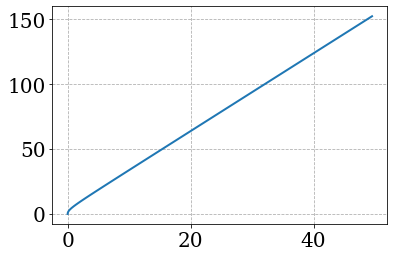

In [4]:

x = 10**np.linspace(-3.5, 1, 100-1)
x = np.concatenate([[0,], x])
m = np.sqrt(1 + x**2)
assert len(np.unique(m)) == len(m)
np.set_printoptions(precision=2**5)
print(m[0:3])
print(p(m[:3]))
plt.plot(p(m), u(m))

In [5]:
u = lambda mu : 1 - 1/mu**2 + 3/2 * (mu**2 - 1/mu**2)
p = lambda mu : 1/mu**2 - 1 + 1/2 * (mu**2 - 1/mu**2)

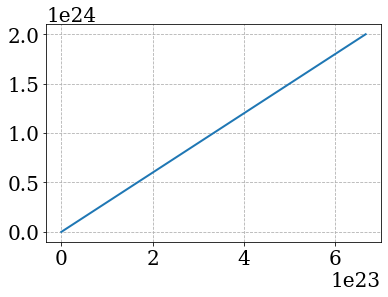

In [10]:
x = sp.Symbol("x")
u_symb = (2*x**3 + x) * sp.sqrt(1 + x**2) - sp.asinh(x) 
p_symb = 1 / 3 * ((2*x**3 - 3*x) * sp.sqrt(1 + x**2) + 3*sp.asinh(x))
ux = sp.lambdify(x, u_symb, "numpy")
px = sp.lambdify(x, p_symb, "numpy")

n = 1000
xlst = 10**np.linspace(-3.5, 6, n-1)
xlst = np.concatenate([[0,], xlst])
plst = px(xlst)
ulst = ux(xlst)

plt.plot(plst, ulst)

In [11]:
x = np.array([0, 1, 2])
y = x[x<-1]**2
print(y)

[]


In [36]:
assert len(np.unique(plst)) == len(plst)
assert len(np.unique(ulst)) == len(ulst)



@njit
def u(p):
    ulst = np.zeros_like(p)
    mask1 = p>0
    mask2 = p>1e10
    mask = np.logical_and(mask1, np.logical_not(mask2))
    ulst[mask] = u0(p[mask])
    ulst[mask2] = 3*p[mask2]
    return ulst



In [47]:
tck = splrep(plst, ulst, s=0, k=3)

def u(p):
    if p < 0: return 0
    if p > 1e10: return 3*p
    else: return splev(p, tck)

In [48]:
u(1)

array(6.55521682)

In [13]:
k = 8/3*(15/8)**(3/5)
def unewt(p):
    ulst = np.zeros_like(p)
    mask = p>0
    ulst[mask] = k*p[mask]**(3/5)
    return ulst
    
plt.plot(plst, u(plst))
plt.plot(plst, unewt(plst))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [49]:
def dmdr_general(u, r, y, args):
    """Mass equation in dimensionless units"""
    p, m = y
    return 3 * u(p) * r**2

def dpdr_general(u, r, y, args):
    """TOV equation in dimensionless units, for general equation of state"""
    p, m = y
    if np.abs(r)<1e-5:
        p0 = args
        u0 = u(p0)
        return - r * (p + u(p)) * (3 * p + u0) / (1 - 2*u0*r**2)
    else:
        return - 1 / r**2 * (p + u(p)) * (3 * p * r**3 + m) /  (1 - 2 * m/r)

def stop(r, y, args):
    """Termiation cirerion"""
    p, m = y
    return p
stop.terminal = True # attribute for solve_ivp


In [50]:
u(np.array([1e6,2e5]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [22]:
from scipy.integrate import solve_ivp

def RK4(f, dr, r, y, args):
    k1 = f(r, y, args) * dr
    k2 = f(r, y + k1 / 2, args) * dr
    k3 = f(r, y + k2 / 2, args) * dr
    k4 = f(r, y + k3, args) * dr
    return 1 / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

def integrate(f, dr0, r0, y0, args):
    r = r0
    y = y0
    dr = dr0
    i = 0
    while True:
        dy = RK4(f, dr, r, y, args)
        if (y[0] + dy[0]) < 0:
            # dr = dr / 10
            # if dr < 1e-4:
            break
        else:
            y += dy
            r += dr
            dr = dr0
            i += 1
        if i>1e4:
            return None
    return (r, y)


In [38]:
log_pmin = -6
log_pmax = 6
N = 100
p0s = 10**np.linspace(log_pmin, log_pmax, N)
sols = []

# Specialize to tehe fermi equation of state
# u = unewt
dpdr = lambda r, y, args: dpdr_general(u, r, y, args)

dmdr = lambda r, y, args: dmdr_general(u, r, y, args)
# Standard ODE form, y'(t) = f(y, t)
def f(r, y, args): 
    dp = dpdr(r, y, args)
    dm = dmdr(r, y, args)
    return np.array([dp, dm])

sol = [None for _ in range(N)]

In [26]:
p0 = 1e6
a = integrate(f, 0.001, 0, (p0, 0), p0)
print(a)

None


In [30]:
for i, p0 in enumerate(tqdm(p0s)):
    s = None
    dr = 0.001
    while s is None:
        s = integrate(f, dr, 0, (p0, 0), (p0))
        dr = dr/10
    sol[i] = s[0], s[1][1]

sol =  np.array(sol)

100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


In [39]:
sols = [None for _ in range(N)]

for i, p0 in enumerate(tqdm(p0s)):
    s = solve_ivp(f, (0, 1e3), (p0, 0), args=(p0,), events=stop, max_step=0.001)
    sols[i] = s

sols2 =  np.array(sols)


  0%|          | 0/100 [00:03<?, ?it/s]


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at /tmp/ipykernel_11905/2925737809.py (10)[0m
[1m
File "../../../../../../tmp/ipykernel_11905/2925737809.py", line 10:[0m
[1m<source missing, REPL/exec in use?>[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class 'function'>[0m


array([3.403e+00, 3.308e+00, 3.216e+00, 3.126e+00, 3.038e+00, 2.953e+00,
       2.869e+00, 2.788e+00, 2.709e+00, 2.632e+00, 2.557e+00, 2.484e+00,
       2.412e+00, 2.342e+00, 2.274e+00, 2.207e+00, 2.142e+00, 2.079e+00,
       2.016e+00, 1.956e+00, 1.896e+00, 1.837e+00, 1.780e+00, 1.724e+00,
       1.669e+00, 1.614e+00, 1.561e+00, 1.509e+00, 1.457e+00, 1.407e+00,
       1.357e+00, 1.308e+00, 1.259e+00, 1.212e+00, 1.165e+00, 1.119e+00,
       1.074e+00, 1.029e+00, 9.860e-01, 9.430e-01, 9.020e-01, 8.610e-01,
       8.220e-01, 7.840e-01, 7.470e-01, 7.110e-01, 6.780e-01, 6.450e-01,
       6.150e-01, 5.860e-01, 5.590e-01, 5.340e-01, 5.120e-01, 4.910e-01,
       4.720e-01, 4.560e-01, 4.430e-01, 4.320e-01, 4.230e-01, 4.180e-01,
       4.160e-01, 4.170e-01, 4.220e-01, 4.300e-01, 4.420e-01, 4.570e-01,
       4.740e-01, 4.920e-01, 5.100e-01, 5.260e-01, 5.390e-01, 5.480e-01,
       5.540e-01, 5.560e-01, 5.550e-01, 5.530e-01, 5.490e-01, 5.440e-01,
       5.390e-01, 5.340e-01, 5.290e-01, 5.250e-01, 

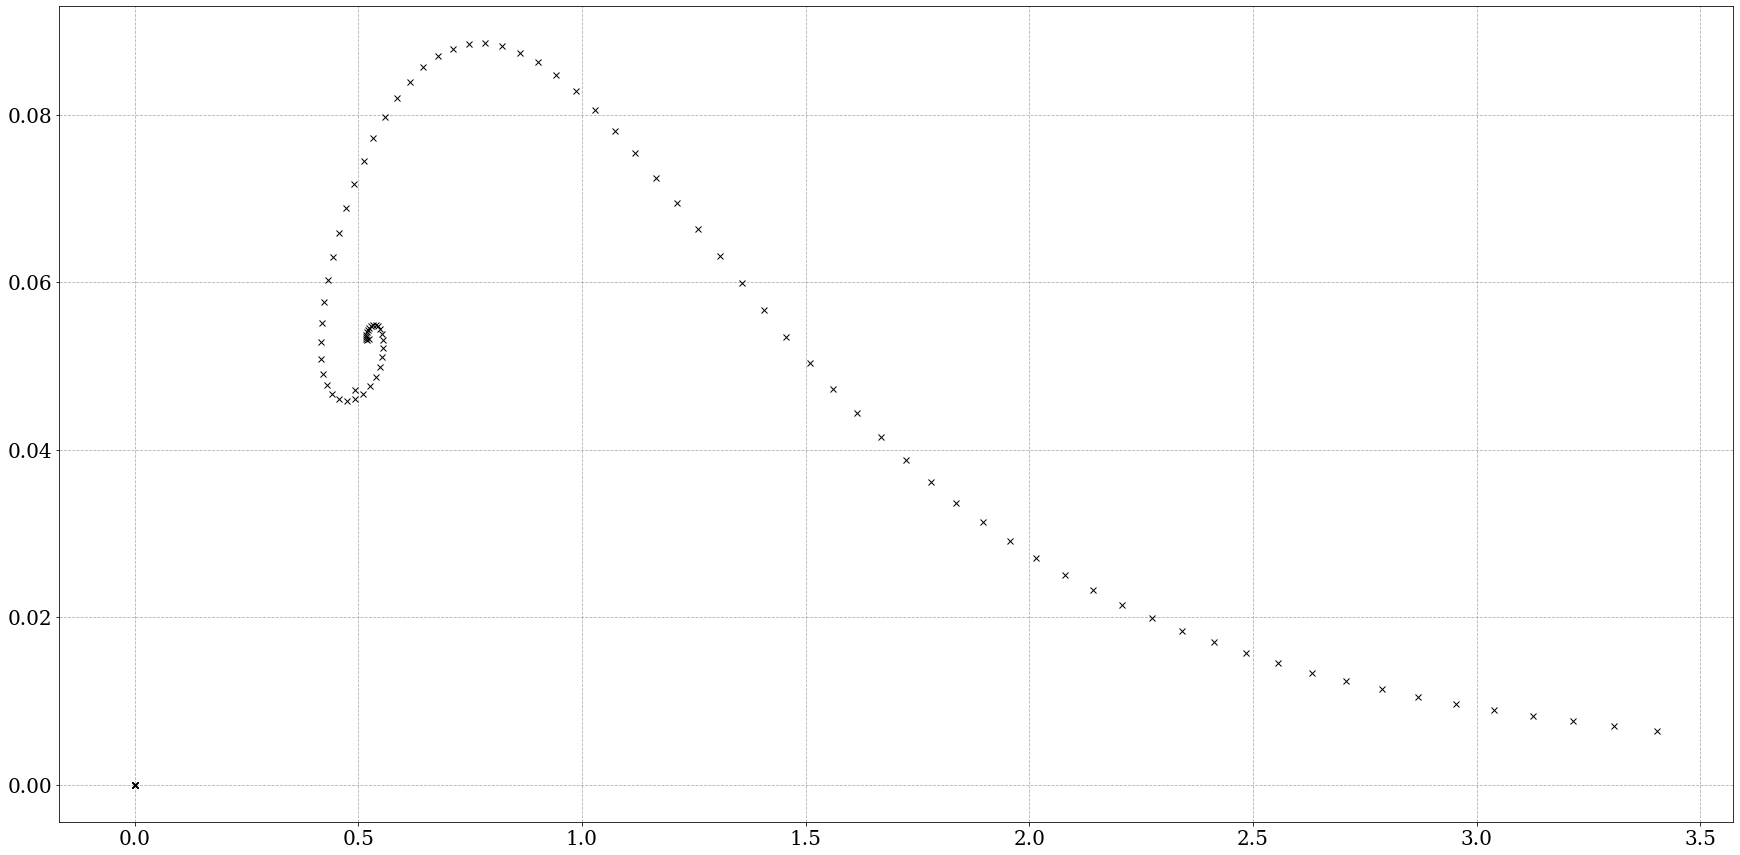

In [35]:
R, M = sol.T

fig, ax = plt.subplots(figsize=(30, 15))

plt.plot(R[:-3], M[:-3],"kx")

# data = [[], [], []]
# for i, s in enumerate(sols2):
#     data[0].append(s.t[-1])
#     data[1].append(s.y[1][-1])
#     data[2].append(s.y[0][0])
# R, M, p0 = [np.array(d) for d in data]
# plt.plot(R, M)

# plt.show()
R